In [3]:
import os
import numpy as np
import cv2
import time
import glob
import math
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision import transforms
import shutil
from matplotlib import pyplot as plt
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import random_split
import os
import numpy as np
import torch
from torchvision import models, transforms
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


from dataset import TrackSet
import utils

#Might need to change "device" to "cpu" if you dont have cuda installed
device = "cuda:2"
#Also, change this to the path where you saved the dataset
data_dir = "./dataset/seedlings_no_background"
training_data = "./dataset/classb"


#Use this to change the name used to save the models and the confusion matrix. 
## BE CAREFUL!!! It will overwrite if the names are the same
model_name = "resnet18"


In [4]:
batch_size = 64
EPOCHS = 10

In [5]:
random_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 30)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)
])

transform = transforms.Compose(
            [
            transforms.ToTensor(),
            random_transforms,
            transforms.Resize((224,224),antialias=None),
            ]
        )

In [ ]:
pre_dataset = ImageFolder(root=data_dir, transform=transform)
pre_data_loader = DataLoader(pre_dataset, batch_size=batch_size)


Here, you need to change the model from here. 
Careful, sometimes the models dont have a layer called"fc", sometimes is called "classifier". 
if you do print(model) you will see the model structure:
After you see teh structure, at the end you will see something like this:

(avgpool): AdaptiveAvgPool2d(output_size=(1, 1)
(fc): Linear(in_features=512, out_features=1000, bias=True)
in parenthesis is the layer name, 


In [7]:

model = models.resnet18(pretrained=True)#.to(device)
num_features = model.fc.in_features
#print(model)
# This is how to load a model which is already been trained. You should not need this code
#model.fc = nn.Linear(num_features, 43).to(device)
#model_check = torch.load("./saved_models/resnet18_pretrained_traffic_lights.pth")
#model.load_state_dict(model_check)

model.fc = nn.Linear(num_features, 2).to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

AssertionError: Torch not compiled with CUDA enabled

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scaler = torch.cuda.amp.GradScaler()
celoss = nn.CrossEntropyLoss()

# Pre - training
This code pretrains the model on the black an white dataset. 

In [6]:

    
loss_list = []
acc_list = []
training_acc_list = []
for epoch in tqdm(range(5), position = 0):
        model.train()
        loop = tqdm(enumerate(pre_data_loader), total = len(pre_data_loader), position = 1)
        correct = 0
        total = 0
        for batch_idx, (data, targets) in loop:
            data, targets = data.to(device),targets.to(device)
            outputs = model(data)

            loss = celoss(outputs, targets) 
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            loss_list.append(loss.item())
            loop.set_postfix(loss = loss.item(), epoch = epoch, model = "simple model for class")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [54]:
# Create a folder called "saved_models" if you dont hav one, otherwise it will cause an error
torch.save(model.state_dict(), f"./saved_models/pre_trained_{model_name}_for_class_wt.pth")

# Starting the real training

Now, once the model has been pretrained, we can start training on the real dataset. 


In [56]:
#Creating the weights for the loss function (the dataset is imbalanced)
print(training_set.classes)
class_counts = [248, 60, 207, 93]  # Number of samples in each class

# Calculate class frequencies
total_samples = sum(class_counts)
class_frequencies = [total_samples / count for count in class_counts]

# Calculate inverse class frequencies
inverse_frequencies = [1 / freq for freq in class_frequencies]

# Normalize the weights
weights = [freq / sum(inverse_frequencies) for freq in inverse_frequencies]

# Create a tensor of class weights
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

['Charlock', 'Priority', 'Stop', 'Sugarbeet']


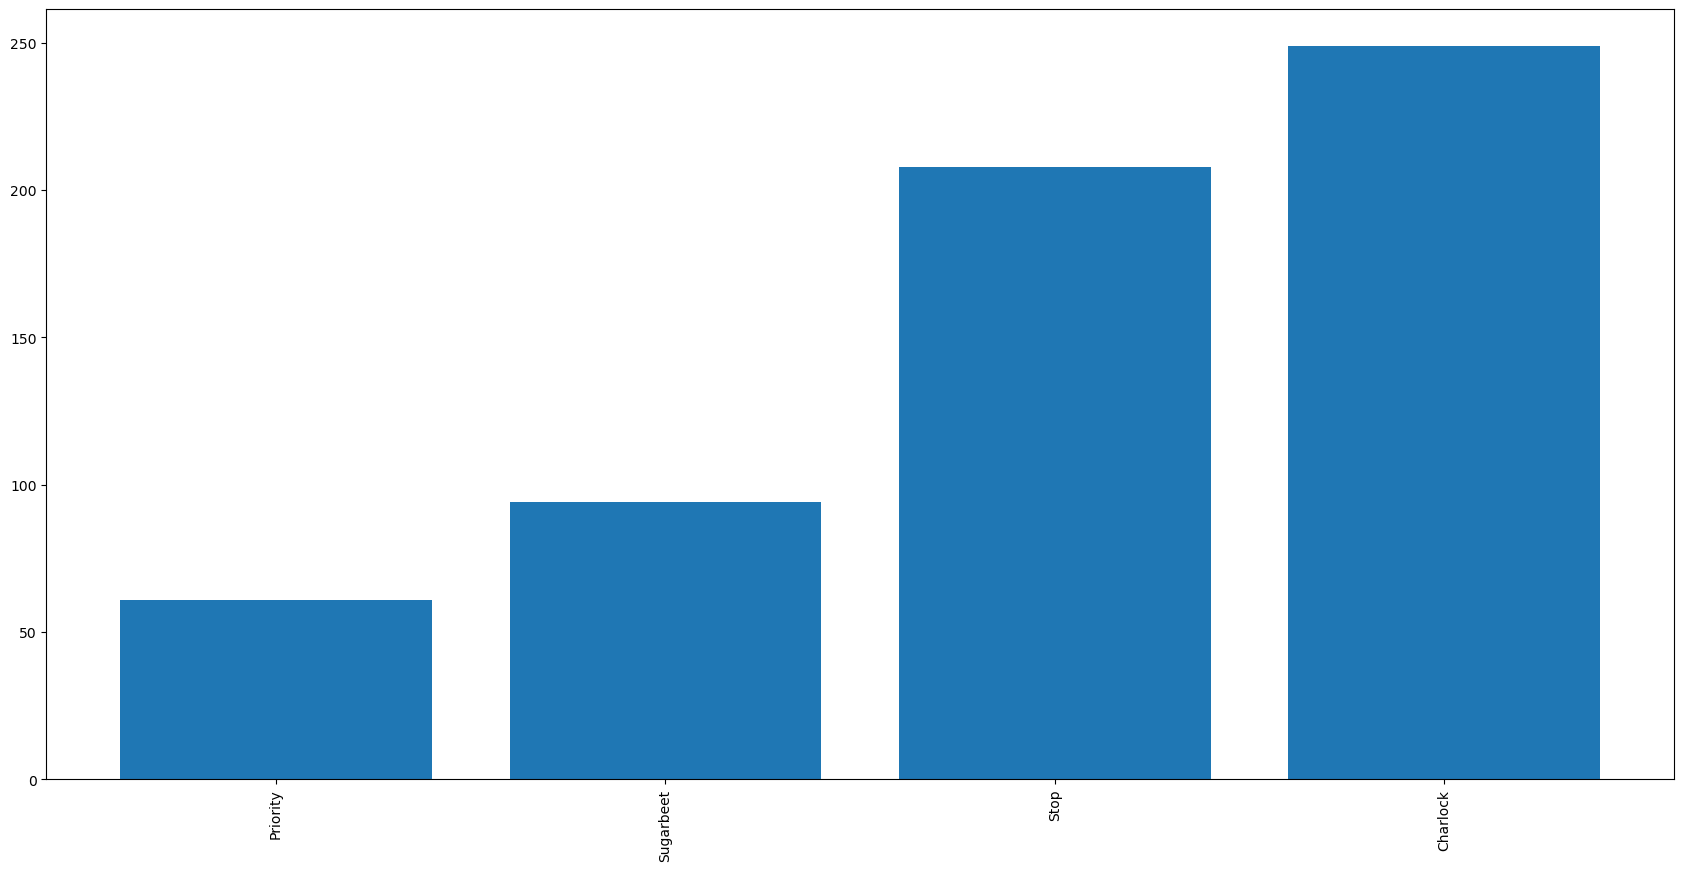

In [58]:
folders = os.listdir(training_data)

train_number = []
class_num = []


for idx,folder in enumerate(training_set.classes):
    train_files = os.listdir(training_data + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(training_set.classes[int(idx)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()


In [59]:

# Creating the dataset for training
training_set = ImageFolder(root=training_data, transform=transform)
validation_ratio = 0.1

# Calculate the number of samples for the validation set
validation_size = int(validation_ratio * len(training_set))
train_size = len(training_set) - validation_size

# Split the training set into training and validation sets
train_set, validation_set = random_split(training_set, [train_size, validation_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=1)

In [60]:
# If you dont want to use the pretrained model, uncomment this line. 
#(Do NOT change pretrained to False)
#model = models.resnet18(pretrained=True).to(device)

    # Modify the last fully connected layer for 4 classes
model.fc = nn.Linear(num_features, 4).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scaler = torch.cuda.amp.GradScaler()


In [11]:
celoss = nn.CrossEntropyLoss(weights_tensor)
    
loss_list = []
acc_list = []
training_acc_list = []
val_correct = 0
val_total=0
for epoch in tqdm(range(5), position = 0):
        #Training
        model.train()
        loop = tqdm(enumerate(train_loader), total = len(train_loader), position = 1)
        correct = 0
        total = 0
        for batch_idx, (data, targets) in loop:
            data, targets = data.to(device),targets.to(device)
            #print(data.shape)
            outputs = model(data)
            loss = celoss(outputs, targets) 
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_list.append(loss.item())
            
            loop.set_postfix(loss = loss.item(), epoch = epoch, model = "simple model for class")
        
        # Calculate validation accuracy
        model.eval()
        y_test = []
        y_pred = []
        inference_times = []
        with torch.no_grad():
            for data, targets in validation_loader:
                    data, targets = data.to(device), targets.to(device)
                    outputs = model(data)

                    
                    start_time = time.time()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    end_time = time.time()
                    val_total += targets.size(0)
                    val_correct += (predicted == targets).sum().item()
                    
                    y_pred.extend(predicted.cpu().numpy().tolist())
                    y_test.extend(targets.cpu().numpy().tolist())
                    inference_time = end_time - start_time
                    inference_times.append(inference_time)
            
            accuracy = accuracy_score(y_test, y_pred)
            val_acc = val_correct / val_total * 100
            acc_list.append(val_acc)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [12]:
torch.save(model.state_dict(), f"./saved_models/{model_name}_for_mnclass.pth")

0.9666666666666667
2.857049306233724e-05


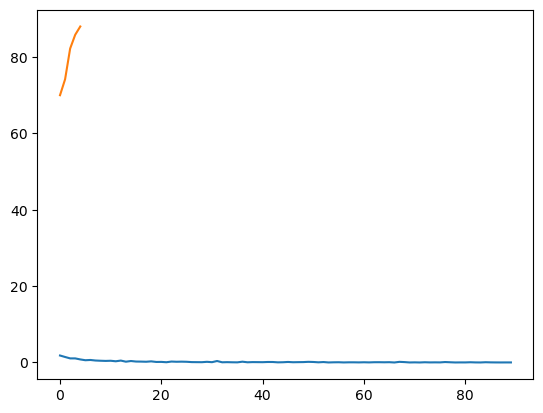

In [13]:
print(accuracy)
print(sum(inference_times)/len(inference_times))
plt.plot(loss_list)
plt.plot(acc_list)

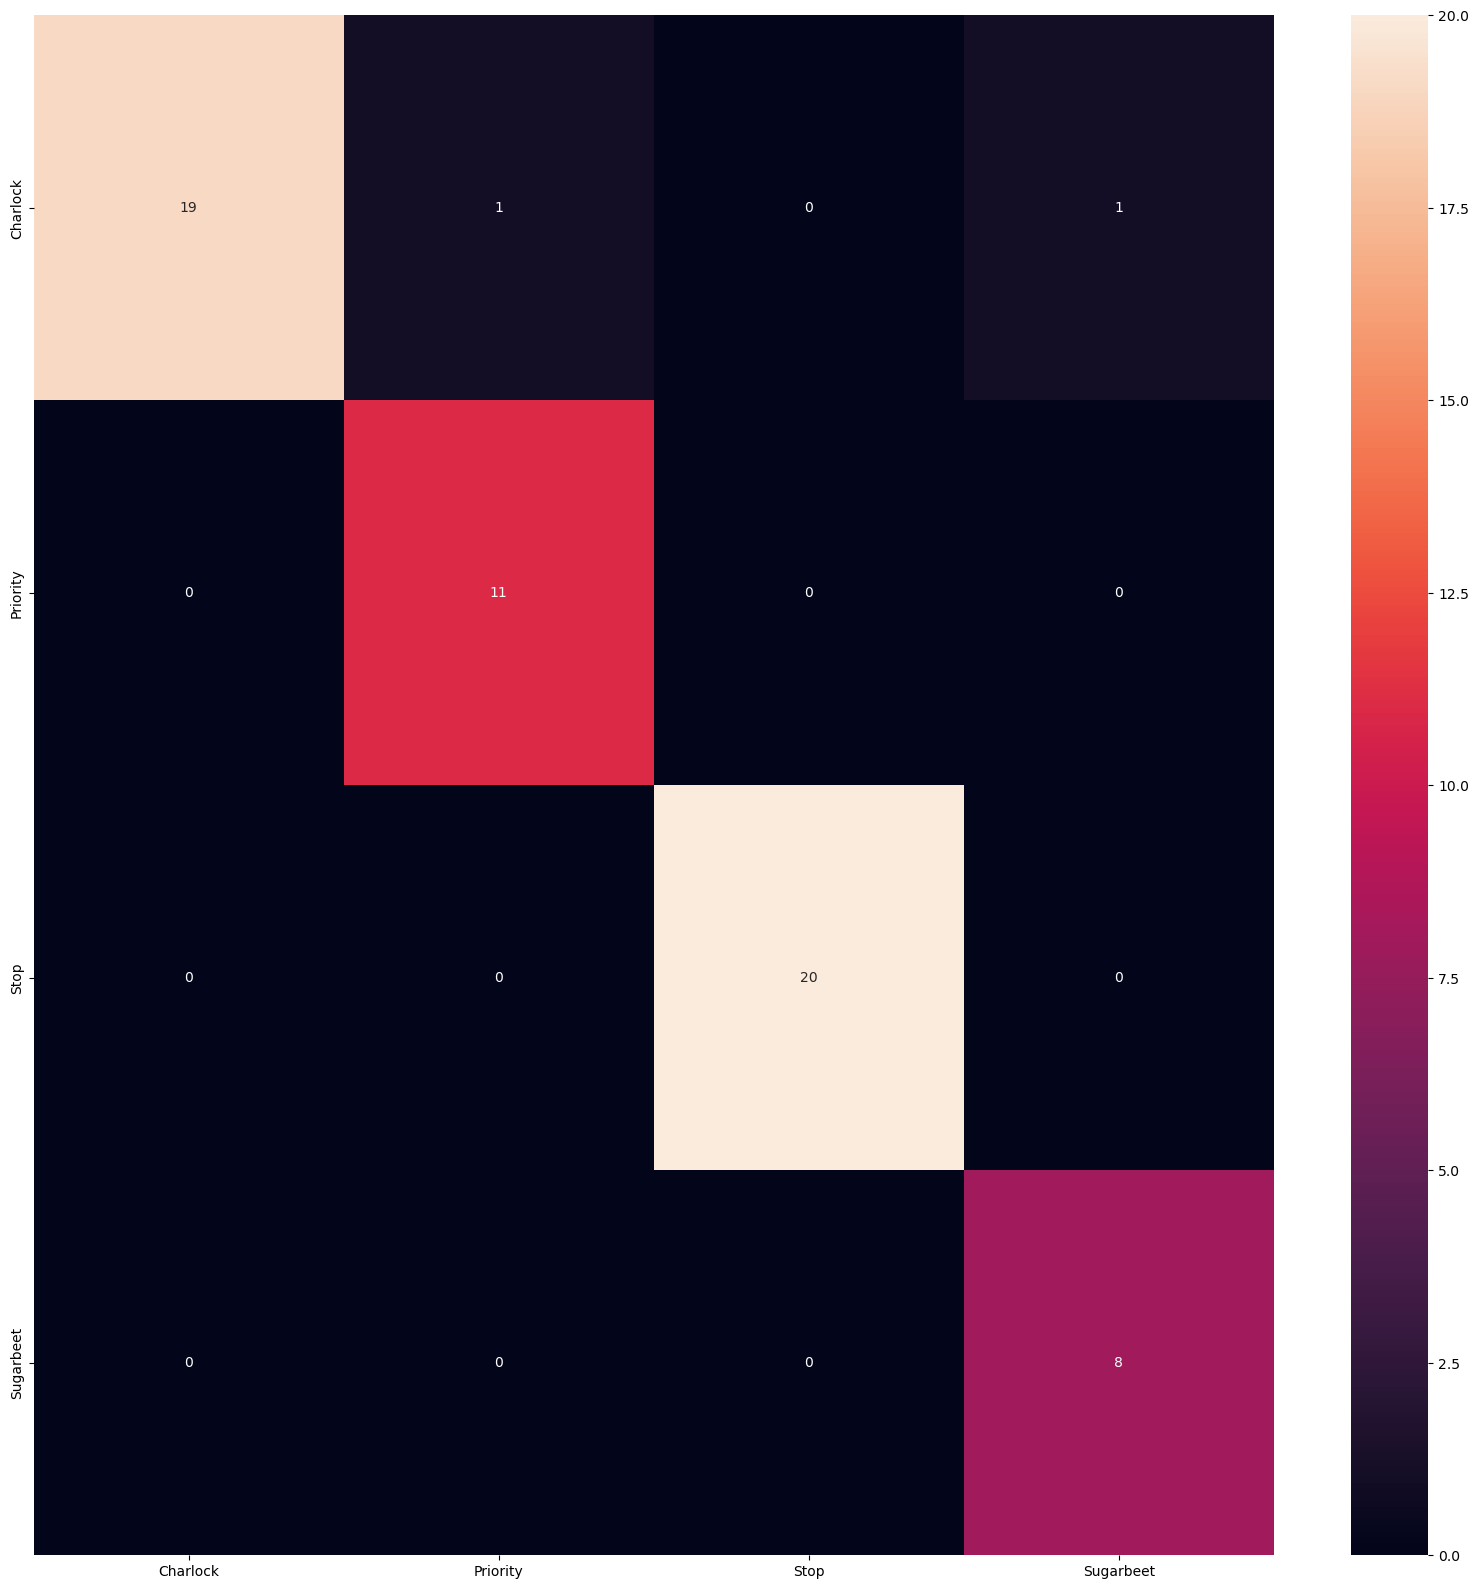

In [52]:
# We need to save this confusion matrix
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_pred, y_test)

import seaborn as sns
df_cm = pd.DataFrame(cf, index = training_set.classes,  columns = training_set.classes)
plt.figure(figsize = (20,20))
fig = sns.heatmap(df_cm, annot=True)
fig.figure.savefig(f"confusion_for_{model_name}.png")

# Extra Work

This is not too much extra work but it's worth doing to see the difference. 
Since the dataset is fairly simple, we can use the neural network to extract features (i.e. edges and some other shit) and then use a simple machine learning technique, in this case svm, to then classify the images. Since the feature extraction is learned during the previous training, this is not causing that much work

In [ ]:

train_loader = DataLoader(training_set, batch_size=1, shuffle=True)

In [ ]:
layer_name = 'avgpool'  # The layer before the fully connected layer
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.eval().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
scaler = torch.cuda.amp.GradScaler()

celoss = nn.CrossEntropyLoss()
    
loss_list = []
#acc_list = []
training_acc_list = []

features = []
labels = []
for epoch in tqdm(range(1), position = 0):
        #Training
        model.train()
        loop = tqdm(enumerate(train_loader), total = len(train_loader), position = 1)
        correct = 0
        total = 0
        for batch_idx, (data, targets) in loop:
            data, targets = data.to(device),targets.to(device)
            #print(data.shape)
            
            with torch.no_grad():
                features += [feature_extractor(data).squeeze().cpu().numpy()]
                labels += [targets.cpu().numpy()]
            

features = np.array(features)
labels = np.array(labels)

# Encode class labels as integers
#print(labels)
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
#X_train.shape
#encoded_labels
# Create an SVM classifier
clf = svm.SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Results so far:

## Resnet18
### Without pre trianing
    93, 96
### Without pre trianing, with feature detector
    97.5
### Without pre trianing, but with weights
    98.3
### Without pre trianing, with feature detector, weights
    98.3
### With pre trianing, with feature detector, weights
    1
### No normalization
    